In [1]:
import tensorflow as tf
import numpy as np
import os
from skimage import io
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Reshape, Softmax,Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
import tensorflow_hub as hub

def load_and_split_image(image_path, img_size=(192, 288)):
    full_image = io.imread(image_path)  
    bscan = full_image[:, :570, :]
    mask = full_image[:, 570:, :]
    bscan = tf.image.resize(bscan, img_size)
    mask = tf.image.resize(mask, img_size)
    return bscan.numpy(), mask.numpy()

In [2]:
COLOR_MAP = {
    (255, 0, 0): 0, (255, 192, 203): 1, (0, 0, 255): 2,
    (0, 255, 0): 3, (255, 255, 0): 4, (0, 0, 0): 5
}

def rgb_to_label(mask_rgb):
    label_mask = np.zeros(mask_rgb.shape[:2], dtype=np.uint8)
    for rgb, class_idx in COLOR_MAP.items():
        matches = np.all(mask_rgb == np.array(rgb), axis=-1)
        label_mask[matches] = class_idx
    return label_mask

In [3]:
def load_dataset_from_txt(txt_path, base_dir, img_size=(192, 288)):
    with open(txt_path, "r") as f:
        filenames = [line.strip() for line in f.readlines()]
    images, masks = [], []
    for filename in filenames:
        eye_id = filename.split("_")[0]
        image_path = os.path.join(base_dir, eye_id, filename)
        bscan, mask_rgb = load_and_split_image(image_path, img_size)
        mask_label = rgb_to_label(mask_rgb)
        images.append(bscan)
        masks.append(mask_label)
    return np.array(images), np.array(masks)


In [4]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Input, Reshape, UpSampling2D, Conv2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda


def vit_encoder(input_shape):
    inputs = Input(input_shape)

    # Resize using a Lambda layer to avoid the KerasTensor error
    resized = Lambda(lambda x: tf.image.resize(x, (224, 224)))(inputs)

    # Normalize images to range [-1, 1] before passing to ViT
    normalized = Lambda(lambda x: (x / 127.5) - 1)(resized)

    # Load ViT model from Kaggle
    vit = hub.KerasLayer("https://www.kaggle.com/models/spsayakpaul/vision-transformer/TensorFlow2/vit-b16-fe/1",
                         trainable=True)

    # Wrap ViT call inside a Lambda layer to avoid symbolic tensor errors
    features = Lambda(lambda x: vit(x))(normalized)

    return Model(inputs, features, name="ViT_Encoder")


In [5]:
from tensorflow.keras.layers import Dense, Reshape, Conv2D, UpSampling2D, Input
from tensorflow.keras.models import Model

def unet_vit_model(input_size=(192, 288, 3), num_classes=6):
    inputs = Input(input_size)

    # Use ViT as encoder
    encoder = vit_encoder(input_size)
    features = encoder(inputs)  # Output shape: (batch_size, 768)

    # Convert ViT output (batch, 768) into a spatial feature map
    x = Dense(24 * 36 * 256, activation="relu")(features)  # Project to a spatial shape
    x = Reshape((24, 36, 256))(x)  # Reshape into 24x36 feature map (adjusted size)

    # Upsample to match U-Net decoder (now target size is 192x288)
    x = UpSampling2D((2, 2))(x)  # (48, 72, 256)
    x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = UpSampling2D((2, 2))(x)  # (96, 144, 128)
    x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = UpSampling2D((2, 2))(x)  # (192, 288, 64)
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)

    # Output layer with softmax activation for multi-class segmentation
    outputs = Conv2D(num_classes, (1, 1), activation="softmax", padding="same")(x)

    return Model(inputs, outputs, name="ViT_UNet")


In [6]:
X_train, Y_train = load_dataset_from_txt("/kaggle/input/amd-sd/AMD-SD/training.txt", "/kaggle/input/amd-sd/AMD-SD/images")
X_val, Y_val = load_dataset_from_txt("/kaggle/input/amd-sd/AMD-SD/validation.txt", "/kaggle/input/amd-sd/AMD-SD/images")

X_train = X_train.astype("float32") / 255.0
X_val = X_val.astype("float32") / 255.0

Y_train = tf.keras.utils.to_categorical(Y_train, num_classes=6)
Y_val = tf.keras.utils.to_categorical(Y_val, num_classes=6)

model = unet_vit_model()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(
    X_train, Y_train, epochs=10, batch_size=8, validation_data=(X_val, Y_val)
)
val_loss, val_accuracy = model.evaluate(X_val, Y_val)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Epoch 1/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 61s 161ms/step - accuracy: 0.8811 - loss: 0.3277 - val_accuracy: 0.9100 - val_loss: 0.2466
Epoch 2/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 31s 104ms/step - accuracy: 0.9088 - loss: 0.2289 - val_accuracy: 0.9105 - val_loss: 0.2400
Epoch 3/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 31s 104ms/step - accuracy: 0.9105 - loss: 0.2200 - val_accuracy: 0.9075 - val_loss: 0.2421
Epoch 4/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 31s 104ms/step - accuracy: 0.9098 - loss: 0.2178 - val_accuracy: 0.9112 - val_loss: 0.2330
Epoch 5/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 30s 104ms/step - accuracy: 0.9113 - loss: 0.2149 - val_accuracy: 0.9105 - val_loss: 0.2316
Epoch 6/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 30s 103ms/step - accuracy: 0.9105 - loss: 0.2140 - val_accuracy: 0.9105 - val_loss: 0.2336
Epoch 7/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 30s 103ms/step - accuracy: 0.9121 - loss: 0.2099 - val_accuracy: 0.9117 - val_loss: 0.2397
Epoch 8/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 30s 103ms/step - accuracy: 0.9124 - loss: 0

22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 332ms/step

Segmentation Evaluation Metrics per Class:
 Class     Dice      IoU  Hausdorff  Precision  F1 Score  Accuracy
     0 0.310846 0.190765  80.230740   0.668470  0.310846  0.914841
     1 1.000000 1.000000        inf   1.000000  1.000000  1.000000
     2 1.000000 1.000000        inf   1.000000  1.000000  1.000000
     3 0.884780 0.884780        inf   1.000000  0.884780  0.999975
     4 0.651494 0.651494        inf   1.000000  0.651494  0.996778
     5 0.953186 0.911079  14.817811   0.920681  0.953186  0.912900
CSV file saved as 'segmentation_evaluation_metrics.csv'


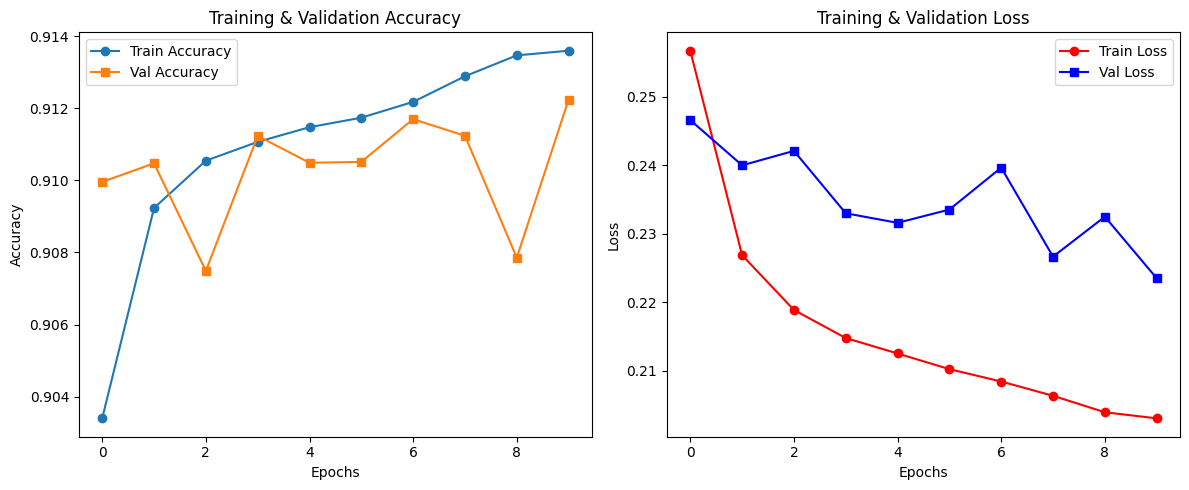

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import directed_hausdorff
from sklearn.metrics import precision_score, f1_score, jaccard_score, accuracy_score

# Define Dice Coefficient
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

# Define IoU Score
def iou_score(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

# Define Hausdorff Distance
def hausdorff_distance(y_true, y_pred):
    y_true_points = np.argwhere(y_true)
    y_pred_points = np.argwhere(y_pred)
    if len(y_true_points) == 0 or len(y_pred_points) == 0:
        return np.inf
    d1 = directed_hausdorff(y_true_points, y_pred_points)[0]
    d2 = directed_hausdorff(y_pred_points, y_true_points)[0]
    return max(d1, d2)

# Get model predictions
y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=-1)  # Convert probabilities to class indices
y_true = np.argmax(Y_val, axis=-1)  # Convert one-hot encoded labels to class indices

num_classes = 6
metrics_accum = {cls: {'dice': [], 'iou': [], 'hausdorff': [], 'precision': [], 'f1': [], 'accuracy': []} for cls in range(num_classes)}

# Compute metrics for each class
for cls in range(num_classes):
    for i in range(len(X_val)):
        y_true_cls = (y_true[i] == cls).astype(np.uint8)
        y_pred_cls = (y_pred[i] == cls).astype(np.uint8)

        dice = dice_coefficient(y_true_cls, y_pred_cls)
        iou = iou_score(y_true_cls, y_pred_cls)
        hd = hausdorff_distance(y_true_cls, y_pred_cls)
        prec = precision_score(y_true_cls.flatten(), y_pred_cls.flatten(), zero_division=1)
        f1_val = f1_score(y_true_cls.flatten(), y_pred_cls.flatten(), zero_division=1)
        acc = accuracy_score(y_true_cls.flatten(), y_pred_cls.flatten())

        metrics_accum[cls]['dice'].append(dice)
        metrics_accum[cls]['iou'].append(iou)
        metrics_accum[cls]['hausdorff'].append(hd)
        metrics_accum[cls]['precision'].append(prec)
        metrics_accum[cls]['f1'].append(f1_val)
        metrics_accum[cls]['accuracy'].append(acc)

# Store metrics in DataFrame
results = {'Class': [], 'Dice': [], 'IoU': [], 'Hausdorff': [], 'Precision': [], 'F1 Score': [], 'Accuracy': []}
for cls in range(num_classes):
    results['Class'].append(cls)
    results['Dice'].append(np.mean(metrics_accum[cls]['dice']))
    results['IoU'].append(np.mean(metrics_accum[cls]['iou']))
    results['Hausdorff'].append(np.mean(metrics_accum[cls]['hausdorff']))
    results['Precision'].append(np.mean(metrics_accum[cls]['precision']))
    results['F1 Score'].append(np.mean(metrics_accum[cls]['f1']))
    results['Accuracy'].append(np.mean(metrics_accum[cls]['accuracy']))

# Convert to DataFrame
df_metrics = pd.DataFrame(results)
print("\nSegmentation Evaluation Metrics per Class:")
print(df_metrics.to_string(index=False))

# Save to CSV
df_metrics.to_csv("segmentation_evaluation_metrics.csv", index=False)
print("CSV file saved as 'segmentation_evaluation_metrics.csv'")

# Plot Evaluation Graphs
plt.figure(figsize=(12, 5))

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy", marker="o")
plt.plot(history.history["val_accuracy"], label="Val Accuracy", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid(False)  # Remove grid lines

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss", marker="o", color="red")
plt.plot(history.history["val_loss"], label="Val Loss", marker="s", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(False)  # Remove grid lines

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


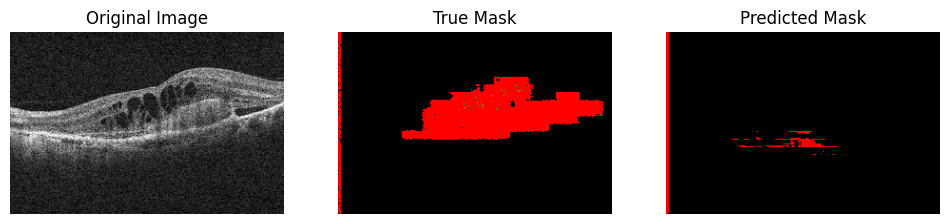

In [8]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Define the color map for converting label indices to RGB
COLOR_MAP = {
    0: (255, 0, 0),  # Red
    1: (255, 192, 203),  # Pink
    2: (0, 0, 255),  # Blue
    3: (0, 255, 0),  # Green
    4: (255, 255, 0),  # Yellow
    5: (0, 0, 0)  # Black (background)
}

def rgb_to_label(mask_rgb):
    label_mask = np.zeros(mask_rgb.shape[:2], dtype=np.uint8)
    for rgb, class_idx in COLOR_MAP.items():
        # Create a boolean mask where the RGB values match
        matches = np.all(mask_rgb == np.array(rgb), axis=-1)
        label_mask[matches] = class_idx
    return label_mask

def label_to_rgb(label_mask):
    # Convert label mask (integer indices) back to RGB
    rgb_mask = np.zeros((label_mask.shape[0], label_mask.shape[1], 3), dtype=np.uint8)
    for class_idx, rgb in COLOR_MAP.items():
        rgb_mask[label_mask == class_idx] = rgb
    return rgb_mask

# Select a sample image and mask from the validation set
sample_image = X_val[1]  # Replace with the image index of your choice
true_mask = Y_val[1]  # The true mask corresponding to the image

# Resize the sample image to match the input shape (192, 288)
sample_image_resized = tf.image.resize(sample_image, (192, 288))  # Resize to (192, 288)
sample_image_resized = sample_image_resized / 127.5 - 1  # Normalize to [-1, 1]
sample_image_resized = np.expand_dims(sample_image_resized, axis=0)  # Add batch dimension

# Make a prediction
predicted_mask = model.predict(sample_image_resized)

# Convert predicted mask from logits to class probabilities
predicted_mask = np.argmax(predicted_mask, axis=-1)  # Shape will be (1, height, width)
predicted_mask = np.squeeze(predicted_mask)  # Remove batch dimension

# Convert the one-hot encoded true mask to a label format
true_label_mask = np.argmax(true_mask, axis=-1)  # Convert from one-hot to label mask

# Convert true and predicted label masks back to RGB
true_rgb_mask = label_to_rgb(true_label_mask)
predicted_rgb_mask = label_to_rgb(predicted_mask)

# Visualize the original image, true mask, and predicted mask
plt.figure(figsize=(12, 12))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(sample_image)
plt.title("Original Image")
plt.axis('off')

# True Mask
plt.subplot(1, 3, 2)
plt.imshow(true_rgb_mask)  # Show the true RGB mask
plt.title("True Mask")
plt.axis('off')

# Predicted Mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_rgb_mask)  # Show the predicted RGB mask
plt.title("Predicted Mask")
plt.axis('off')

plt.show()


Shape of true_mask before processing: (192, 288, 6)
Shape of label_mask after squeezing: (192, 288, 6)
Shape of label_mask after selecting first channel: (192, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Shape of label_mask after squeezing: (192, 288)


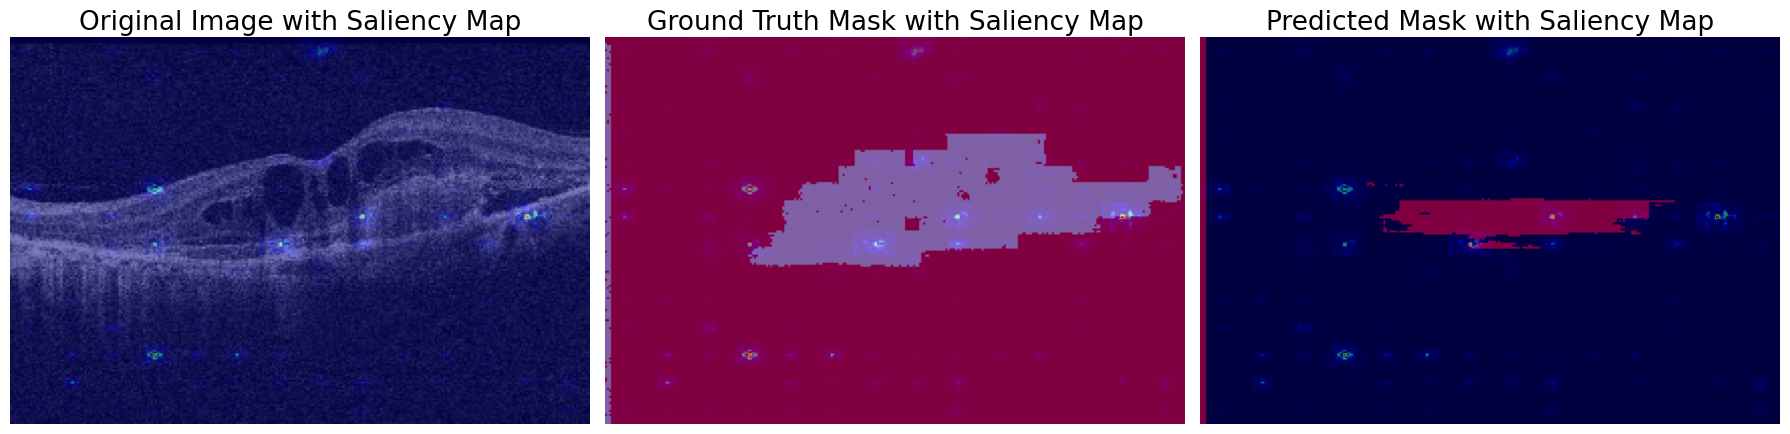

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Select an image from the validation set
manual_idx = 6
img = X_val[manual_idx]  # Original OCT scan
true_mask = Y_val[manual_idx]  # Ground truth segmentation mask

# Debugging: Print the shape of true_mask
print("Shape of true_mask before processing:", true_mask.shape)

# Convert the true mask to RGB for visualization
def label_to_rgb(label_mask):
    # Ensure label_mask is 2D by squeezing and indexing if necessary
    label_mask = np.squeeze(label_mask)  # Remove single-dimensional entries
    
    # Debugging: Print the shape after squeezing
    print("Shape of label_mask after squeezing:", label_mask.shape)
    
    # Handle cases where label_mask still has more than 2 dimensions
    if len(label_mask.shape) > 2:
        # If there are multiple channels, take the first channel
        label_mask = label_mask[:, :, 0]
        print("Shape of label_mask after selecting first channel:", label_mask.shape)
    
    # Now unpack the shape
    H, W = label_mask.shape
    rgb_mask = np.zeros((H, W, 3), dtype=np.uint8)
    
    # Define a color map for different labels
    COLOR_MAP = {
    0: (255, 0, 0),  # Red
    1: (255, 192, 203),  # Pink
    2: (0, 0, 255),  # Blue
    3: (0, 255, 0),  # Green
    4: (255, 255, 0),  # Yellow
    5: (0, 0, 0)  # Black (background)
}
    
    for class_idx, color in COLOR_MAP.items():
        rgb_mask[label_mask == class_idx] = color
    
    return rgb_mask

# Ensure true_mask is 2D before passing it to label_to_rgb
true_mask_rgb = label_to_rgb(true_mask)

# Function to compute saliency maps
class SaliencyMap:
    def __init__(self, model):
        self.model = model

    def __call__(self, input_tensor, class_idx=None):
        # Ensure the input tensor has batch dimension
        input_tensor = tf.convert_to_tensor(input_tensor[np.newaxis, ...], dtype=tf.float32)
        
        with tf.GradientTape() as tape:
            tape.watch(input_tensor)
            predictions = self.model(input_tensor)  # Shape: (1, H, W, num_classes)
            
            # If no class index is specified, use the predicted class for the first pixel
            if class_idx is None:
                class_idx = tf.argmax(predictions[0, 0, 0])  # Get class of first pixel
            
            # Compute loss as sum of probabilities for the target class across all pixels
            loss = tf.reduce_sum(predictions[:, :, :, class_idx])

        # Compute gradients of the loss w.r.t. the input image
        grads = tape.gradient(loss, input_tensor)[0]  # Remove batch dimension
        
        # Compute the absolute value of gradients and normalize
        saliency = tf.reduce_max(tf.abs(grads), axis=-1)  # Max across RGB channels
        saliency = (saliency - tf.reduce_min(saliency)) / (tf.reduce_max(saliency) - tf.reduce_min(saliency) + 1e-6)
        return saliency.numpy()

# Initialize Saliency Map
saliency_map = SaliencyMap(model)

# Generate the saliency map for a specific class (e.g., class 3)
saliency = saliency_map(img, class_idx=3)

# Predict the segmentation mask using the trained model
predicted = model.predict(np.expand_dims(img, axis=0))
predicted_mask = np.argmax(predicted[0], axis=-1)  # Shape: (192, 288)
predicted_mask_rgb = label_to_rgb(predicted_mask)  # Convert predicted mask to RGB

# Plot the results
plt.figure(figsize=(18, 6))

# Panel 1: Saliency map overlaid on the original image
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.imshow(saliency, cmap="jet", alpha=0.5)
plt.title("Original Image with Saliency Map", fontsize=19)
plt.axis("off")

# Panel 2: Saliency map overlaid on the ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(true_mask_rgb)
plt.imshow(saliency, cmap="jet", alpha=0.5)
plt.title("Ground Truth Mask with Saliency Map", fontsize=19)
plt.axis("off")

# Panel 3: Saliency map overlaid on the predicted mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_rgb)
plt.imshow(saliency, cmap="jet", alpha=0.5)
plt.title("Predicted Mask with Saliency Map", fontsize=19)
plt.axis("off")

# Save the figure
plt.tight_layout()
plt.savefig("/kaggle/working/saliency_visualization.png")  # Save as PNG
plt.show()

Initial shape of true_mask: (192, 288, 6)
Shape of label_mask after squeezing: (192, 288, 6)
Shape of label_mask after selecting first channel: (192, 288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Shape of label_mask after squeezing: (192, 288)


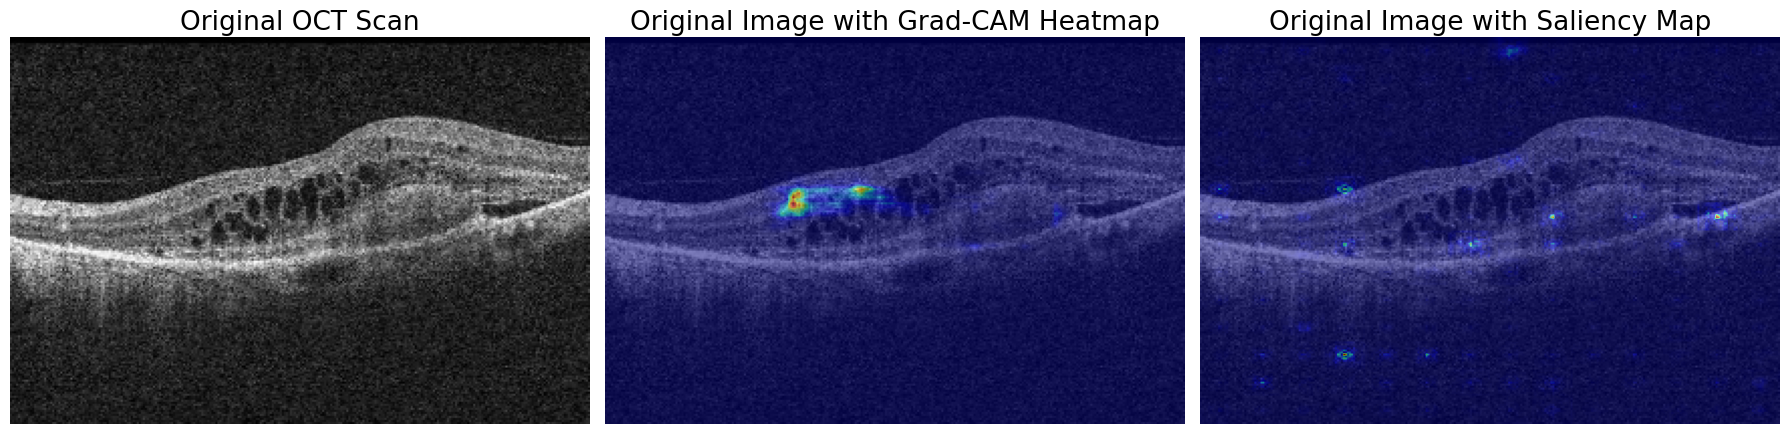

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Install the grad-cam library if not already installed
!pip install grad-cam

# Select an image from the validation set
manual_idx = 20
img = X_val[manual_idx]  # Original OCT scan
true_mask = Y_val[manual_idx]  # Ground truth segmentation mask

# Debugging: Print the initial shape of true_mask
print("Initial shape of true_mask:", true_mask.shape)

# Convert the true mask to RGB for visualization
def label_to_rgb(label_mask):
    # Ensure label_mask is 2D by squeezing extra dimensions
    label_mask = np.squeeze(label_mask)  # Remove single-dimensional entries
    
    # Debugging: Print the shape after squeezing
    print("Shape of label_mask after squeezing:", label_mask.shape)
    
    # Handle cases where label_mask still has more than 2 dimensions
    if len(label_mask.shape) > 2:
        # If there are multiple channels, take the first channel
        label_mask = label_mask[:, :, 0]
        print("Shape of label_mask after selecting first channel:", label_mask.shape)
    
    # Now unpack the shape
    H, W = label_mask.shape
    rgb_mask = np.zeros((H, W, 3), dtype=np.uint8)
    
    # Define the global COLOR_MAP
    COLOR_MAP = {
        0: (255, 0, 0),      # Red
        1: (255, 192, 203),  # Pink
        2: (0, 0, 255),      # Blue
        3: (0, 255, 0),      # Green
        4: (255, 255, 0),    # Yellow
        5: (0, 0, 0)         # Black (background)
    }
    
    # Assign colors based on the mask values
    for class_idx, color in COLOR_MAP.items():
        rgb_mask[label_mask == class_idx] = color
    
    return rgb_mask

# Ensure true_mask is 2D before passing it to label_to_rgb
true_mask_rgb = label_to_rgb(true_mask)

# Apply Grad-CAM to the student model
layer_name = "conv2d_3"  # Replace with the name of a convolutional layer in your model

# Wrap the TensorFlow/Keras model in a GradCAM-compatible class
class KerasGradCAM:
    def __init__(self, model, layer_name):
        self.model = model
        self.layer_name = layer_name

    def __call__(self, input_tensor, class_idx=None):
        # Ensure the input tensor has batch dimension
        input_tensor = np.expand_dims(input_tensor, axis=0)
        
        # Create a sub-model that outputs both the target layer and the model predictions
        grad_model = tf.keras.models.Model(
            inputs=self.model.inputs,
            outputs=[self.model.get_layer(self.layer_name).output, self.model.output]
        )

        # Use GradientTape to compute gradients
        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(input_tensor)
            
            # If no class index is specified, use the predicted class for the first pixel
            if class_idx is None:
                class_idx = tf.argmax(predictions[0, 0, 0])  # Get class of first pixel
            
            # Compute loss as sum of probabilities for the target class across all pixels
            loss = tf.reduce_sum(predictions[:, :, :, class_idx])

        # Compute gradients of the loss w.r.t. the target layer output
        grads = tape.gradient(loss, conv_outputs)[0]
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1))  # Global average pooling

        # Weight the feature maps by the pooled gradients
        conv_outputs = conv_outputs[0]
        heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
        heatmap = np.maximum(heatmap, 0)  # ReLU activation
        heatmap /= np.max(heatmap) if np.max(heatmap) > 0 else 1  # Normalize
        
        # Return the heatmap (already a NumPy array)
        return heatmap  # Removed .numpy() here

# Initialize Grad-CAM
grad_cam = KerasGradCAM(model, layer_name="conv2d_3")

# Generate the heatmap
heatmap = grad_cam(img, class_idx=3)  # Specify class_idx if needed (e.g., class 3)

# Resize the heatmap to match the dimensions of the input image and ground truth mask
heatmap_resized = tf.image.resize(heatmap[np.newaxis, ..., np.newaxis], 
                                  img.shape[:2],
                                  method=tf.image.ResizeMethod.BILINEAR).numpy()[0, :, :, 0]

# Predict the segmentation mask using the trained model (distiller)
predicted = model.predict(np.expand_dims(img, axis=0))
predicted_mask = np.argmax(predicted[0], axis=-1)  # Shape: (192, 288)
predicted_mask_rgb = label_to_rgb(predicted_mask)  # Convert predicted mask to RGB

# Plot the results
plt.figure(figsize=(18, 6))

# Panel 1: Heatmap overlaid on the original image
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original OCT Scan", fontsize=19)
plt.axis("off")

# Panel 2: Heatmap overlaid on the original image
plt.subplot(1, 3, 2)
plt.imshow(img)
plt.imshow(heatmap_resized, cmap="jet", alpha=0.5)
plt.title("Original Image with Grad-CAM Heatmap", fontsize=19)
plt.axis("off")

# Panel 3: Saliency map overlaid on the original image
plt.subplot(1, 3, 3)
plt.imshow(img)
plt.imshow(saliency, cmap="jet", alpha=0.5)
plt.title("Original Image with Saliency Map", fontsize=19)
plt.axis("off")

# Save the figure
plt.tight_layout()
plt.savefig("/kaggle/working/gradcam1_visualization.png")  # Save as PNG
plt.show()